In [1]:
print("Hello World")

Hello World


In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import warnings
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
warnings.filterwarnings('ignore')

In [3]:
DATASET_PATH='/Users/lokeshnagasaidarla/Developer/webdev/sleep-health-cardio-prediction/dataset/'
df = pd.read_csv(os.path.join(DATASET_PATH, "raw_data.csv"))

In [4]:
df.head()

,Person ID,Gender,Age,Occupation,SleepDuration,QualityOfSleep,PhysicalActivityLevel,StressLevel,BMICategory,BloodPressure,HeartRate,DailySteps,SleepDisorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [5]:
df=df.drop(columns=['Person ID'])

In [6]:
bins = [0, 20, 30, 40, 50, 60, 70]
labels = ['<20', '21-30', '31-40', '41-50', '51-60', '61-70']
df['Age Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

In [7]:
bp_split = df['BloodPressure'].str.split('/', expand=True)
df['Systolic'] = bp_split[0].astype(int)
df['Diastolic'] = bp_split[1].astype(int)
df.drop(columns=['BloodPressure'], inplace=True)

In [8]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

In [9]:
class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    """Applies Label Encoding to specific columns."""
    def __init__(self, columns):
        self.columns = columns
        self.label_encoders = {col: LabelEncoder() for col in columns}
    
    def fit(self, X, y=None):
        for col in self.columns:
            self.label_encoders[col].fit(X[col])
        return self
    
    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            X[col] = self.label_encoders[col].transform(X[col])
        return X


In [10]:
column_transformer = ColumnTransformer(
            transformers=[
                ('num', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='mean')),
                    ('scaler', StandardScaler())
                ]), ['Systolic', 'Diastolic']),
                ('gender', OneHotEncoder(drop='first'), ['Gender']),
                ('label_encoder', LabelEncoderTransformer(columns=['Occupation', 'BMICategory', 'Age Group']), ['Occupation', 'BMICategory', 'Age Group'])
            ],
            remainder='passthrough'
        )

In [11]:
# Split the data into features and target variable
X = df.drop(columns=['SleepDisorder'])
y = df['SleepDisorder']

# Train-test split


In [12]:
X.head()

,Gender,Age,Occupation,SleepDuration,QualityOfSleep,PhysicalActivityLevel,StressLevel,BMICategory,HeartRate,DailySteps,Age Group,Systolic,Diastolic
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,21-30,126,83
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,21-30,125,80
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,21-30,125,80
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,21-30,140,90
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,21-30,140,90


In [13]:
y=y.fillna('No Disorder')

In [14]:
column_transformer.fit(X)
X=column_transformer.transform(X)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
X_test.shape

(75, 13)

In [17]:
# Create and train the Decision Tree model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

In [18]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

Accuracy: 0.89
Classification Report:
               precision    recall  f1-score   support

    Insomnia       0.76      0.81      0.79        16
 No Disorder       0.95      0.98      0.97        43
 Sleep Apnea       0.86      0.75      0.80        16

    accuracy                           0.89        75
   macro avg       0.86      0.85      0.85        75
weighted avg       0.89      0.89      0.89        75



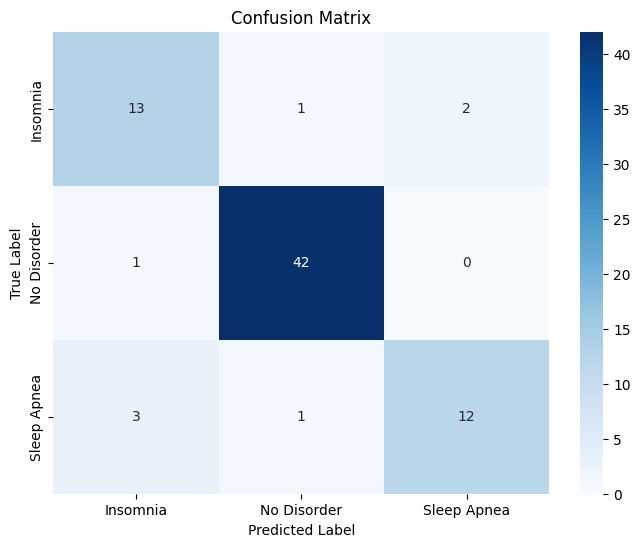

In [19]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)  # Use output_dict for better formatting
conf_matrix = confusion_matrix(y_test, y_pred)

report_df = pd.DataFrame(report).transpose()

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Text(0, 0.5, 'Importance')

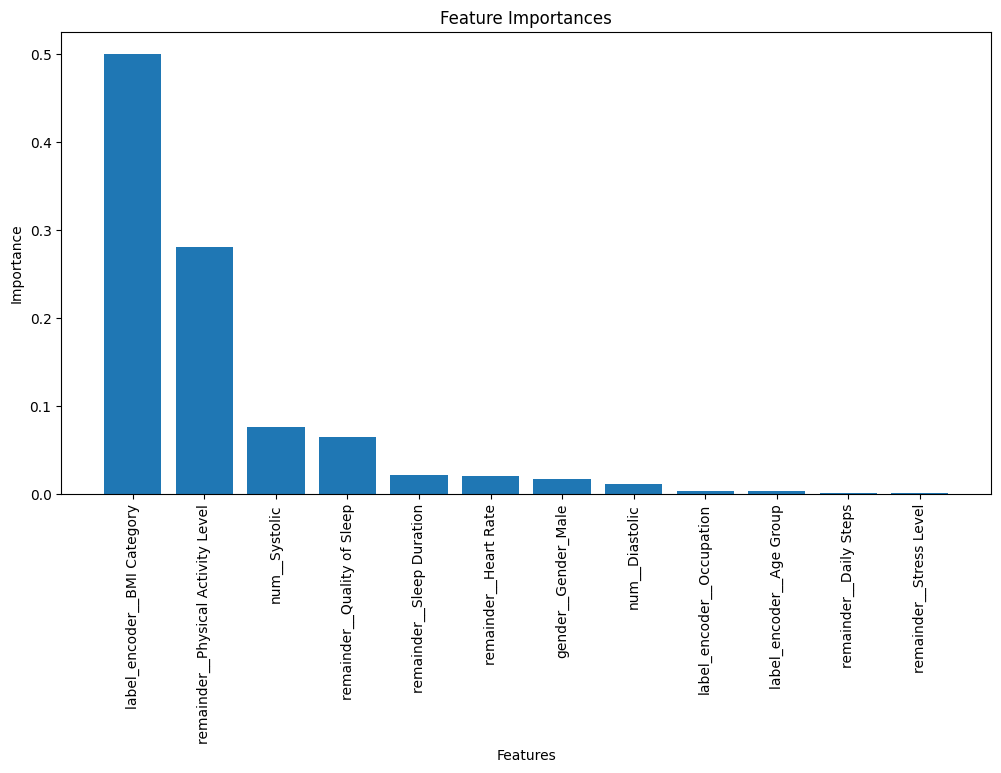

In [ ]:
importances = clf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

# Plotting Feature Importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.xlabel('Features')
plt.ylabel('Importance')

In [21]:
# Save the model
MODELS_PATH='/Users/lokeshnagasaidarla/Developer/webdev/sleep-health-cardio-prediction/models/'
with open(os.path.join(MODELS_PATH, "dt_model.pkl"), 'wb') as file:
    pickle.dump(clf, file)